# Behavioral Cloning

Remaining things to do:  

1. Collect more data by going round Track 1 counter clockwise.   
2. Collect more data by going on Track 2.  

## Admin

Load packages

In [1]:
# standard
import numpy as np
import pandas as pd
import random 
import os

# image processing
import cv2
# from imgaug import augmenters as iaa


# 
import matplotlib.mlab as mlab

# read data
import csv

# data visualization
import matplotlib.pyplot as plt

In [2]:
from sklearn.utils import shuffle

Set notebook parameters

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)

In [5]:
# set data location for local machine
# data_loc = '/media/fqaiser94/ff3daf1f-fc36-43a4-a218-478126941f2a/behavioral-data/'

# set data location for AWS
# data_loc = '/home/carnd/Behavioral-data/data/'
data_loc = '/home/carnd/farooq_data/'

In [6]:
batch_size = 32

## Tidy data

Transform the data into a "tidy" state.  

In [7]:
raw_data = pd.read_csv(
    data_loc + 'driving_log.csv', index_col=False)

raw_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2017_12_11_22_00_16_852.jpg,IMG/left_2017_12_11_22_00_16_852.jpg,IMG/right_2017_12_11_22_00_16_852.jpg,0.0,0.0,0.0,0.000002
1,IMG/center_2017_12_11_22_00_16_951.jpg,IMG/left_2017_12_11_22_00_16_951.jpg,IMG/right_2017_12_11_22_00_16_951.jpg,0.0,0.0,0.0,0.000001
2,IMG/center_2017_12_11_22_00_17_018.jpg,IMG/left_2017_12_11_22_00_17_018.jpg,IMG/right_2017_12_11_22_00_17_018.jpg,0.0,0.0,0.0,0.000007
3,IMG/center_2017_12_11_22_00_17_102.jpg,IMG/left_2017_12_11_22_00_17_102.jpg,IMG/right_2017_12_11_22_00_17_102.jpg,0.0,0.0,0.0,0.000002
4,IMG/center_2017_12_11_22_00_17_202.jpg,IMG/left_2017_12_11_22_00_17_202.jpg,IMG/right_2017_12_11_22_00_17_202.jpg,0.0,0.0,0.0,0.000008


In [8]:
images_paths = []
steering_angles = []
camera = []

angle_shift_dict = dict({
        'left': 0.25, 
        'center': 0.00, 
        'right': -0.25
    })

for i in ['left', 'center', 'right']: 
    
    image_path = raw_data[i].tolist()
    
    angle = raw_data['steering'] + angle_shift_dict.get(i)
    
    images_paths.extend(image_path)
    steering_angles.extend(angle)

In [9]:
# make normalized df
tidy_data =  pd.DataFrame({'image_path': images_paths, 
                          'steering_angle': steering_angles})

tidy_data.head()

,image_path,steering_angle
0,IMG/left_2017_12_11_22_00_16_852.jpg,0.25
1,IMG/left_2017_12_11_22_00_16_951.jpg,0.25
2,IMG/left_2017_12_11_22_00_17_018.jpg,0.25
3,IMG/left_2017_12_11_22_00_17_102.jpg,0.25
4,IMG/left_2017_12_11_22_00_17_202.jpg,0.25


## EDA

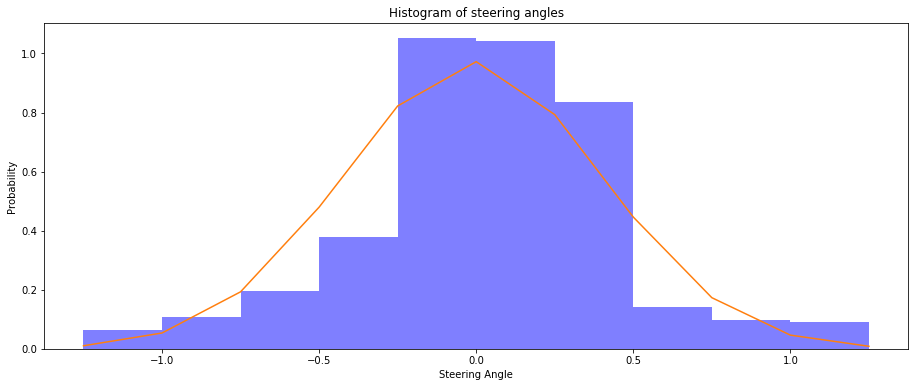

In [10]:
num_bins = 10
# the histogram of the data
n, bins, patches = plt.hist(tidy_data.steering_angle, num_bins, normed=1, facecolor='blue', alpha=0.5)
 
# add a 'best fit' line
mu = np.mean(tidy_data.steering_angle)
sigma = np.std(tidy_data.steering_angle)
y = mlab.normpdf(bins, mu, sigma)

plt.plot(bins, y)
plt.xlabel('Steering Angle')
plt.ylabel('Probability')
plt.title('Histogram of steering angles')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

The vast majority of steering angles distributed around 0.  
If we're not careful about this, our model may be biased towards steering straight. Naturally this would be a problem when we encounter turns.  

## Training and validation data

Split data into training and validation.  
We don't need testing data as we will simply get our model to drive a car around a track for testing purposes. 

In [11]:
tidy_data = shuffle(tidy_data)

In [12]:
total_samples = len(tidy_data)

In [13]:
training_count = int(0.8 * total_samples)

In [14]:
training_data = tidy_data[:training_count].reset_index()
validation_data = tidy_data[training_count:].reset_index()

In [15]:
print('Total number of samples: %s' %total_samples)
print('')
print('Training samples: %s' %len(training_data))
print('Validation samples: %s' %len(validation_data))

Total number of samples: 51585

Training samples: 41268
Validation samples: 10317


## Data generator

Too much data to fit into memory.  
We will use a generator to 'yield' data as needed. 

In [16]:
def sample_data(data, batch_size):
    """
    Randomly samples data from a given df  
    """
    
    return data.sample(n=batch_size)

In [17]:
def generate_bins(data, number_of_bins):
    
    # bin data 
    bins = np.linspace(
        start = data.steering_angle.min(), 
        stop = data.steering_angle.max(), 
        num = number_of_bins
    )

    return bins

In [18]:
generate_bins(tidy_data, 10)

array([-1.25      , -0.97222222, -0.69444444, -0.41666667, -0.13888889,
        0.13888889,  0.41666667,  0.69444444,  0.97222222,  1.25      ])

In [19]:
def sample_data_uniformly(data, bins, batch_size):
    """
    Randomly samples from each bin in data from a given df  
    """
    
    data['steering_angle_bin'] = pd.cut(
        x=data.steering_angle, 
        bins=bins
    )

    data = (
        data
        .groupby('steering_angle_bin')
        .apply(lambda x: x.sample(batch_size, replace=True))
        .reset_index(drop=True)
        #.drop('steering_angle_bin') # dont know why this isn't working
        .sample(batch_size, replace=True) 
    )
    
    return data

In [20]:
def get_image(data, 
              data_path, 
              index):
    """
    get image and angle
    """
    
    image_path = data['image_path'][index].strip()
    imageBGR = cv2.imread(os.path.join(data_path, image_path))
    
    # cv2.imread reads in images in BGR format. 
    # drive.py actually sends images in RGB format to our model
    # therefore we need to train our model on RGB images
    imageRGB = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB)
    
    steering_angle = float(data['steering_angle'][index])
    
    return imageRGB, steering_angle

In [21]:
image, steering_angle = get_image(data=tidy_data, data_path=data_loc, index=1)

image.shape

(160, 320, 3)

In [22]:
def rgb2y(array):
    """
    convert array of images from RGB to Y
    """
    
    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        img_yuv = cv2.cvtColor(np.array(array[i], dtype=np.uint8), cv2.COLOR_BGR2YUV, 1)
        y, u, v = cv2.split(img_yuv)
        
        y_reshaped = np.reshape(y, y.shape + (1,))

        array_y[i] = y_reshaped
        
    return array_y

In [23]:
def flip_images(image, angle): 
    
    image_flipped = np.fliplr(image)
    angle_flipped = -angle
    
    return image_flipped, angle_flipped

In [24]:
def data_generator(data, data_path, batch_size):
    """
    generates image and label data
    """
    
    while 1:
        
        # init features and label arrays
        features = np.empty([batch_size, 160, 320, 3])
        labels = np.empty([batch_size, 1])
        
        # sample a batch of data 
        batch = sample_data(
            data=data, 
            batch_size=batch_size
        )
        
        # sample data uniformly
        #bins = generate_bins(data, 10)
        
        #batch = sample_data_uniformly(
        #    data=data, 
        #    batch_size=batch_size, 
        #    bins=bins
        #)
        
        # convert to single channel?
        
        
        # flip images to create more data
        
        
        # translate images to create more data
        
        
        # return image features and label
        for i, value in enumerate(batch.index.values):
            
            # get image
            image, steering_angle  = get_image(data = data, 
                                               data_path = data_path, 
                                               index = value)
            
            #images = []
            #angles = []
            
            # og image
            #images.append(image)
            #angles.append(measurement)
            
            # og image flipped
            #images.append(cv2.flip(image,1))
            #angles.append(measurement*-1.0)
            
            features[i] = image
            labels[i] = steering_angle
            
            yield np.array(features), np.array(labels)

In [25]:
# initialize generators
train_generator = data_generator(
    data=training_data, 
    data_path=data_loc,
    batch_size=batch_size
)

validation_generator = data_generator(
    data=validation_data, 
    data_path=data_loc,
    batch_size=batch_size
)

## NVIDIA model 

Our model will be based on an architecture previously developed at NVIDIA.  

![NVIDIA Self Driving Car Architecture](https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture-624x890.png)

For more information, see the following [link](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/). 

In [26]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D

Using TensorFlow backend.


In [27]:
def NVIDIA_model():
    """
    Creates nVidea Autonomous Car Group model
    """
    
    # 
    model = Sequential()

    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

    # crop images to reduce memory impact and remove noise
    # returns img of shape (80,320,3)
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    
    model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu'))
    model.add(Convolution2D(36, (5,5), strides=(2,2), activation='relu'))
    model.add(Convolution2D(48, (5,5), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    
    # compile
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [28]:
# init model
model = NVIDIA_model()

In [29]:
# fit  
history_object = model.fit_generator(
    
    generator = train_generator, 
    steps_per_epoch = len(training_data)/batch_size, 
    
    validation_data = validation_generator,
    validation_steps = len(validation_data)/batch_size, 
    
    epochs=5, 
    verbose=1
)

Epoch 1/5
1290/1289 [==============================] - 126s 98ms/step - loss: 0.0906 - val_loss: 0.1186
Epoch 2/5
1290/1289 [==============================] - 122s 95ms/step - loss: 0.0714 - val_loss: nan
Epoch 3/5
1290/1289 [==============================] - 122s 95ms/step - loss: 0.0874 - val_loss: 0.1314
Epoch 4/5
1290/1289 [==============================] - 122s 95ms/step - loss: 0.0792 - val_loss: 0.1024
Epoch 5/5
1290/1289 [==============================] - 122s 94ms/step - loss: 0.0930 - val_loss: 0.1002


In [30]:
# save model
model.save('model_20171215_2020.h5')

dict_keys(['loss', 'val_loss'])


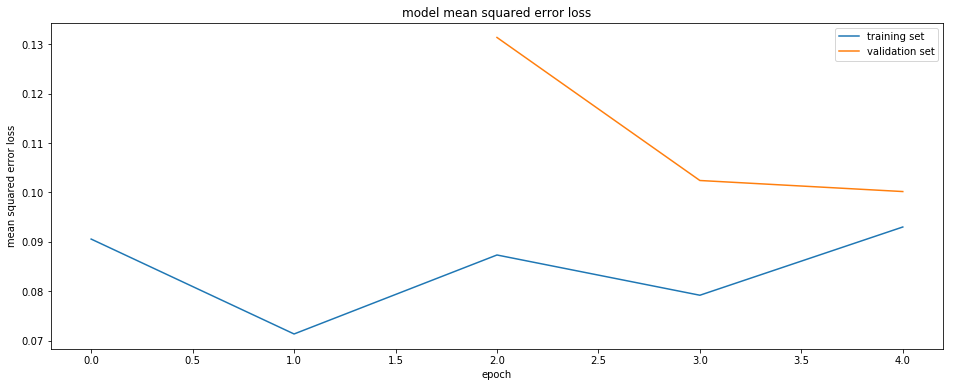

In [31]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

## Preprocess data

### Image flip
To combat this bias, we'll do flip some images to create "new" images. 

In [32]:
angle_max = mu + sigma
angle_min = mu - sigma

print(angle_max)
print(angle_min)

0.397986273257
-0.422367110695


In [33]:
temp = np.where((angles > angle_max) | (angles < angle_min))

images_flipped = np.fliplr(images[temp])
angles_flipped = -angles[temp]

temp_images = np.vstack((images, images_flipped))
temp_angles = np.hstack((angles, angles_flipped))

NameError: name 'angles' is not defined

### Uniform sampling 

In [ ]:
angles_bins = np.digitize(angles, bins)
angles_y = np.array([y[i-1] for i in angles_bins])

In [ ]:
new = np.array([])

for bin_number in np.unique(angles_bins): 
    
    i = np.where(angles_bins==bin_number)
    i = np.array(i).flatten()
    i_random = np.random.choice(a=i, size=500,replace=True)

    new = np.hstack((new, i_random))
    
new.shape

In [ ]:
images_uni_sample = np.array([images[int(i)] for i in new])
angles_uni_sample = np.array([angles[int(i)] for i in new])

In [ ]:
num_bins = 30

n, bins, patches = plt.hist(angles_uni_sample, num_bins, normed=1, facecolor='blue', alpha=0.5)

# plt.plot(bins, y)
plt.xlabel('Steering Angle')
plt.ylabel('Probability')
plt.title('Histogram of steering angles')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()